In [74]:
from datasets import load_dataset
dataset = load_dataset("yasimed/lung_cancer")

In [84]:
print(len(dataset['train']))    

613


In [89]:
from PIL import Image
import numpy as np
import os

# Create a directory to save images
os.makedirs('lung_images', exist_ok=True)

def save_image(image_data, index, label):
    # If image_data is a PIL Image, save it directly
    if isinstance(image_data, Image.Image):
        image = image_data
    else:
        # Convert image_data to numpy array if necessary
        image_array = np.array(image_data)

        # Convert numpy array to PIL image
        image = Image.fromarray(image_array)

    # Save the image
    image.save(f'lung_images/image_{label}.png')

count = 0
l = 0
# Iterate through the dataset
for i, example in enumerate(dataset['train']):
    image_data = example.get('image')  # Use .get() to avoid KeyError
    print(example.get('text'))
    if image_data is not None:
        if "adenocarcinoma" in example.get('text') and count == 0:
            save_image(image_data, i, "adenocarcinoma")
            count += 1
        elif "large cell carcinoma" in  example.get('text') and count == 1:
            save_image(image_data, i, "large_cell_carcinoma")
            count += 1
        elif "squamous cell carcinoma" in  example.get('text') and count == 3:
            save_image(image_data, i, "squamous_cell_carcinoma")
            count += 1
        elif "normal" in example.get('text') and count == 2:
            save_image(image_data, i, "normal")
            count += 1
    
    if count > 3:
        break

    '''
    # Optional: Break after a certain number of images
    if i >= 10:  # Adjust this number as needed
        break
    '''


an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer
an ultrasound photo of adenocarcinoma lung cancer


# Lung Cancer Detection

In [90]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from datasets import load_dataset

In [91]:
dataset = load_dataset("yasimed/lung_cancer", split = "train")

In [92]:
def transforms(examples):
    examples["pixel_values"] = [image.convert("RGB").resize((100,100)) for image in examples["image"]]
    return examples
dataset = dataset.map(transforms, remove_columns=["image"], batched=True)
dataset[0]

{'text': 'an ultrasound photo of adenocarcinoma lung cancer',
 'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=100x100>}

In [93]:
#count_a, count_lc, count_sc, count_n, count_other = 0, 0, 0, 0, 0

def map_text_to_label(examples):
    text = examples['text'].lower()
    if "adenocarcinoma" in text:
        examples['label'] = 1  # Adenocarcinoma
    elif "large cell carcinoma" in text:
        examples['label'] = 2  # Large Cell Carcinoma
    elif "squamous cell carcinoma" in text:
        examples['label'] = 3  # Squamous Cell Carcinoma
    elif "normal" in text:
        examples['label'] = 0  # Normal
    else:
        raise ValueError(f"Unknown text label: {text}")
    return examples

# Apply the function to map text to labels
dataset = dataset.map(map_text_to_label)

# Check the dataset to ensure labels have been added correctly
print(dataset[0])


# an ultrasound photo of adenocarcinoma lung cancer
# an ultrasound photo of large cell carcinoma lung cancer
# an ultrasound photo of squamous cell carcinoma lung cancer
# an ultrasound photo of normal lung

{'text': 'an ultrasound photo of adenocarcinoma lung cancer', 'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=100x100 at 0x2981E4CFDA0>, 'label': 1}


In [94]:
from tensorflow.keras.utils import to_categorical

# Assuming your labels are in the 'label' column
# Ensure num_classes is set to the number of unique labels
num_classes = 4  # Since we have labels 0, 1, 2, 3

# Convert labels to categorical format
labels = to_categorical(dataset["label"], num_classes=num_classes)

# Verify the shape of the labels
print(labels.shape)


(613, 4)


In [95]:
from sklearn.model_selection import train_test_split

# Assuming the dataset is already in the right format with 'pixel_values' and 'label' columns
def split_dataset(dataset):
    # Convert to pandas DataFrame for easy splitting
    import pandas as pd
    df = pd.DataFrame(dataset)

    # Split into training + validation and test sets
    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    # Further split the training + validation set into training and validation sets
    train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)
    
    return train_df, val_df, test_df

# Split the dataset
train_df, val_df, test_df = split_dataset(dataset)


In [96]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoded format
num_classes = 4
train_labels = to_categorical(train_df['label'], num_classes=num_classes)
val_labels = to_categorical(val_df['label'], num_classes=num_classes)
test_labels = to_categorical(test_df['label'], num_classes=num_classes)


In [97]:
def df_to_tf_dataset(df, labels):
    pixel_values = np.array(list(df['pixel_values']))
    labels = np.array(labels)
    return tf.data.Dataset.from_tensor_slices((pixel_values, labels))

# Convert DataFrames to TensorFlow datasets
train_tf_dataset = df_to_tf_dataset(train_df, train_labels).batch(32).prefetch(tf.data.AUTOTUNE)
val_tf_dataset = df_to_tf_dataset(val_df, val_labels).batch(32).prefetch(tf.data.AUTOTUNE)
test_tf_dataset = df_to_tf_dataset(test_df, test_labels).batch(32).prefetch(tf.data.AUTOTUNE)


In [59]:
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential([
    Input(shape=(100, 100, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer should match num_classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
'''

In [98]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # Adjust number of classes

# Define new model
model = Model(inputs=base_model.input, outputs=x)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=10
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3841 - loss: 9.1338 - val_accuracy: 0.6633 - val_loss: 1.8619
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8338 - loss: 0.7146 - val_accuracy: 0.7551 - val_loss: 1.3193
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9046 - loss: 0.3223 - val_accuracy: 0.7755 - val_loss: 1.3026
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9478 - loss: 0.1443 - val_accuracy: 0.8367 - val_loss: 0.8187
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9869 - loss: 0.0550 - val_accuracy: 0.8469 - val_loss: 0.7905
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9960 - loss: 0.0281 - val_accuracy: 0.8469 - val_loss: 0.7392
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.8469 - val_loss: 0.7512
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9960 - loss: 0.0271 - val_accuracy: 0.8469 - val_loss:

In [99]:
test_loss, test_acc = model.evaluate(test_tf_dataset)
print(f"Test accuracy: {test_acc}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 923ms/step - accuracy: 0.8214 - loss: 1.0132
Test accuracy: 0.8373983502388


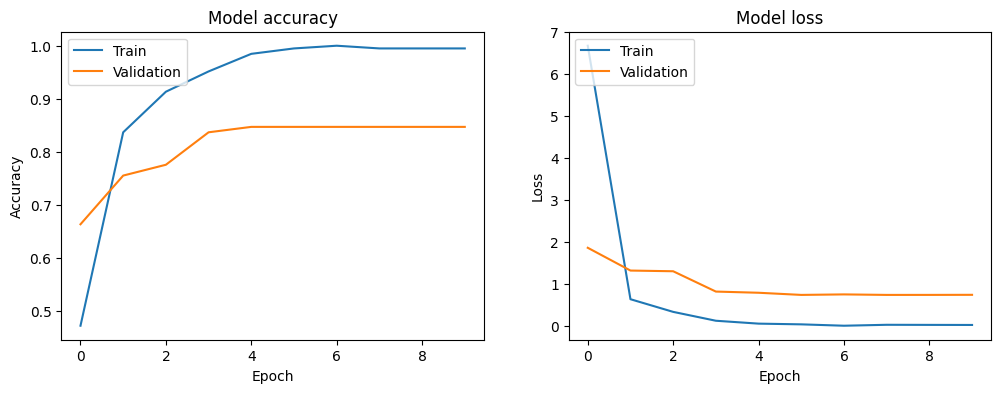

In [103]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [110]:
from PIL import Image
import numpy as np

def preprocess_image(image_path, target_size=(100, 100)):
    # Load the image
    image = Image.open(image_path)
    
    # Convert image to RGB
    image = image.convert("RGB")
    
    # Resize image to match the input size of the model
    image = image.resize(target_size)
    
    # Convert image to numpy array
    image_array = np.array(image)
    
    # Normalize the image
    image_array = image_array / 255.0
    
    # Expand dimensions to match the model input shape (1, height, width, channels)
    image_array = np.expand_dims(image_array, axis=0)
    
    return image_array

# Example usage
image_path = 'lung_images/image_squamous_cell_carcinoma.png'  # Path to the image you want to test
preprocessed_image = preprocess_image(image_path)


In [111]:
# Make predictions
predictions = model.predict(preprocessed_image)

# Get the predicted class (the index of the highest probability)
predicted_class = np.argmax(predictions[0])

# Print the prediction
print(f"Predicted class index: {predicted_class}")

# Optionally, you can map class indices to human-readable labels
class_labels = ['normal', 'adenocarcinoma', 'large cell carcinoma', 'squamous cell carcinoma']
print(f"Predicted class label: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted class index: 2
Predicted class label: large cell carcinoma
